In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt

### Introduction to SOM algorithm


A self organizing map is composed of a grid of neurons that are learned with an unsupervised algorithm. The neurons will learn a prototype and a relative position to other neurons in the embedding space.

We will be working with 2D maps. That means that our SOM map will be `n_row * n_col * n_feat`.

Where 

- `n_row` is the number of rows in the feature map
- `n_col` is the number of cols in the feature map
- `n_feat` is the number of features used to represent the input vectors of the SOM map.



In [3]:
n_row = 32
n_col = 32
n_feat = 3
np.random.seed(123)
node_vectors = np.random.rand(n_row, n_col, n_feat) 
node_vectors.shape

(32, 32, 3)

### Mapping the best match into a 2d grid

We want to define a bijection between 2d coordinates in a matrix and a single vector.

We want to do this for two main reasons:

- we might want to use a distance function build to compute pairwise distances between two matrices, hence, we need our data to be organized as a 2D matrix, instead of a 3D matrix.

- We want to be able to map a row index from the 2D matrix containing all prototypes as rows to a 2D plane of prototypes, to be able to define a neighbourhood.

#### Example

We want to map this:
```
[0,0] [0,1] [0,2] 
[1,0] [1,1] [1,2]
```
To `np.array([0,1,2,3,4,5]).T`

Note that

```
0      1     2  
[0,0] [0,1] [0,2] 
3      4     5
[1,0] [1,1] [1,2]
```

If we know that the array is `[2,3]` then given an index such as `i`
we can do 

In [4]:
def onedim_index_to_twodim(index, n_row, n_col):
    x = index // n_col
    y = index % n_col
    return (x,y)

In [5]:
def twodim_index_to_onedim(row, col, len_row):
    one_dim_index = (row * len_row) + col
    return one_dim_index 

In [6]:
for i in range(2):
    for j in range(3):
        print(f'({i},{j}) --> {twodim_index_to_onedim(i,j,3)}')

(0,0) --> 0
(0,1) --> 1
(0,2) --> 2
(1,0) --> 3
(1,1) --> 4
(1,2) --> 5


In [7]:
n_row = 2
n_col = 3 

for i in range(6):
    print(f'{i} --> {onedim_index_to_twodim(i,2,3)}')

0 --> (0, 0)
1 --> (0, 1)
2 --> (0, 2)
3 --> (1, 0)
4 --> (1, 1)
5 --> (1, 2)


### Finding the best prototype neuron

Given an input vector to the som we want to know which prototype is the best match, the one with lowest distance.

We have a function `euclidean` that is capable to compute, given two matrices, the pairwise distance between the rows of both input matrices.

In [8]:
from utils import euclidean

In [9]:
n_row = 32
n_col = 32
n_features = 3

x = np.array([[0.25, 0.25, 0.25]])
x.shape, node_vectors.shape

((1, 3), (32, 32, 3))

In [10]:
node_vectors_mat = node_vectors.reshape(n_row * n_col, n_features)
node_vectors_mat.shape

(1024, 3)

We can compute the distance between `x` and `node_vectors_mat` as follows

In [11]:
distances = euclidean(x, node_vectors_mat)
distances.shape

(1, 1024)

Finding the closest prototype from `node_vectors_mat`

In [12]:
distances

array([[0.44852719, 0.58408694, 0.88114854, ..., 0.58104996, 0.91759821,
        0.73372179]])

In [13]:
best_match_index = np.argmin(distances)

In [14]:
best_match_index

452

In [15]:
best_match_2d_pos = onedim_index_to_twodim(best_match_index, n_row, n_col)

In [16]:
def grid_neurons(n_row, n_col):
    points = []
    for i in range(n_row):
        for j in range(n_col):
            points.append((i,j))
    
    points = np.array(points)
    return points

def plot_grid(n_row, n_col, grid_neurons, best_match_pos=None):
    plt.figure(figsize=(6,6))
    
    plt.scatter(grid_neurons[:,0], grid_neurons[:,1])
    if best_match_pos is not None:
        plt.scatter(best_match_pos[0],best_match_pos[1], color='red')

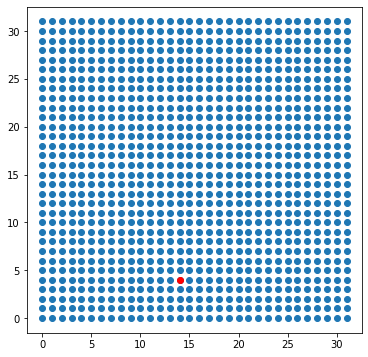

In [17]:
grid = grid_neurons(n_row, n_col)
plot_grid(n_row, n_col, grid,  best_match_2d_pos)

### Finding the neighbors of the best prototype

Assuming that we have found the best prototype in the grid, we want to know who are its neighbors


In [18]:
def find_neighbours(best_match_pos, grid_3d, n_neighbors):
    x, y  = best_match_pos
    selected_points = np.vstack(grid_3d[max(x - n_neighbors,0):x + n_neighbors+1,
                                        max(y - n_neighbors,0):y + n_neighbors+1])
    return selected_points


In [19]:
def plot_neighbours(best_match_pos, grid_3d, n_neighbors):
    """
    Neighbors
    """
    assert grid_3d.ndim == 3, f'grid_3d expects ndim to be 2 but it recieved an array of ndim {grid_3d.ndim} '
    
    selected_points = find_neighbours(best_match_pos, grid_3d, n_neighbors)
    
    plt.figure(figsize=(6,6))
    
    grid = np.vstack(grid_3d)
    plt.scatter(grid[:,0], grid[:,1])
    
    grid_neighbours_2d= np.vstack(selected_points)
    plt.scatter(grid_neighbours_2d[:,0], grid_neighbours_2d[:,1], color = 'pink')

    if best_match_pos is not None:
        plt.scatter(best_match_pos[0],best_match_pos[1], color='red')
    

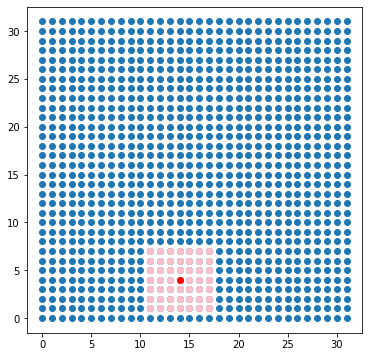

In [20]:
grid_3d = grid.reshape(n_row, n_col, 2)
plot_neighbours(best_match_2d_pos, grid_3d, n_neighbors=3)

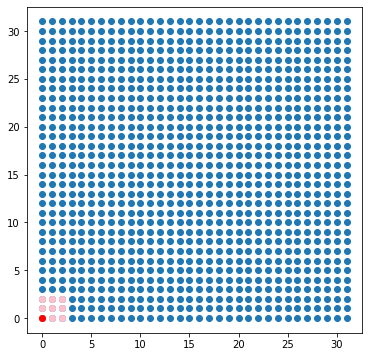

In [21]:
plot_neighbours((0,0), grid_3d, n_neighbors=2)

#### Optimizing finding neighbours


Note that there is no need to keep in memory `grid_3d` in order to get the nearby elements of coordinate

In [22]:
def find_neighbours_fast(point, n_neighbours, n_row, n_col):
    x, y = point
    
    points = []
    weights = []
    for i in range(max(x-n_neighbours,0),min(x+n_neighbours+1,n_col)):
        for j in range(max(y-n_neighbours,0),min(y+n_neighbours+1,n_col)):
            points.append((i,j))
            weights.append( 1/(abs(x-i) + abs(y-j)+1) )
            
    return points, np.array(weights)

In [23]:
%timeit find_neighbours_fast((10,10),n_neighbours=2,n_row=32,n_col=32)

10.8 µs ± 108 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [24]:
%timeit find_neighbours((10,10),grid_3d,2)

8.06 µs ± 394 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [25]:
res1,weights = find_neighbours_fast((10,10),n_neighbours=2,n_row=32,n_col=32)
res2 = find_neighbours((10,10),grid_3d,2)

In [26]:
np.testing.assert_almost_equal(res1, res2)

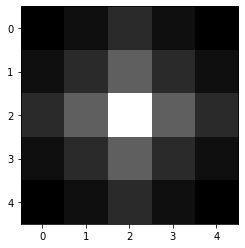

In [27]:
plt.imshow(weights.reshape((5,5)), cmap="gray")

#### Plot neighborhood with weighted colors

The SOM algorithm updates more neurons that are closer to the winning neuron.
Therfore our previous plot of neighbors is does not show this information.

Let us plot it.

In [28]:
def plot_neighbours(best_match_pos, grid_3d, n_neighbors):
    """
    Neighbors
    """
    assert grid_3d.ndim == 3, f'grid_3d expects ndim to be 2 but it recieved an array of ndim {grid_3d.ndim} '
    
    selected_points, weights = find_neighbours_fast(best_match_pos, 
                                                    n_neighbours=n_neighbors,
                                                    n_row=32,
                                                    n_col=32)

    plt.figure(figsize=(6,6))
    
    grid = np.vstack(grid_3d)
    plt.scatter(grid[:,0], grid[:,1], alpha=0.1)
    
    #grid_neighbours_2d = np.vstack(selected_points)
    weights = weights.flatten()
    for xy, w in zip(selected_points, weights):
        plt.scatter(xy[0], xy[1],alpha=w, color = 'pink')


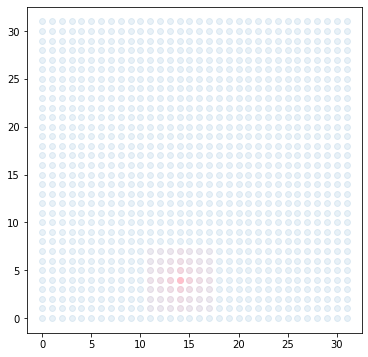

In [29]:
plot_neighbours(best_match_2d_pos, grid_3d, n_neighbors=3)

## Updating neuron weights


https://en.wikipedia.org/wiki/Self-organizing_map



In [30]:
n_row = 32
n_col = 32
n_features = 3

x = np.array([[0.25, 0.25, 0.25]])

In [31]:
node_vectors_mat.shape

(1024, 3)

In [32]:
def fit(X, node_vectors_mat, n_epochs, n_neighbors, n_row=32, n_col=32, n_print = 100):
    
    n_samples, n_features = X.shape
    
    lr = 0.01
    total_dist = 0
    distance_evol = []
    
    for epoch in range(n_epochs):
        perm = np.random.permutation(n_samples)
        for i in perm:
            x = X[[i],:]
            distances = euclidean(x, node_vectors_mat)
            best_match_index = np.argmin(distances)
            best_prototype = node_vectors_mat[best_match_index]
            #best_prototype = node_vectors_mat[[best_match_index]]
            best_match_2d_pos = onedim_index_to_twodim(best_match_index, n_row, n_col)

            selected_points, weights = find_neighbours_fast(best_match_2d_pos, 
                                                            n_neighbours=n_neighbors,
                                                            n_row=n_row,
                                                            n_col=n_col)
            weights = weights.reshape(-1,1)
            total_dist += distances[0,best_match_index]
            
            # Update single wining neuron
            #node_vectors_mat[best_match_index,:] += lr * (x.flatten() - best_prototype)
            
            # Update whole neighborhood
            selected_points_1d = [twodim_index_to_onedim(p[0],p[1],n_col) for p in selected_points]
            node_vectors_mat[selected_points_1d,:] += weights * lr * (x-best_prototype)
            
            # Update whole neighborhood with 
            #selected_points_1d = [twodim_index_to_onedim(p[0],p[1],n_col) for p in selected_points]
            #update = weights * lr * (x-node_vectors_mat[selected_points_1d,:] )
            #node_vectors_mat[selected_points_1d,:] += update
            
        distance_evol.append(total_dist)
        
        if epoch % n_print == 0:
            print(f'\repoch={epoch}, distance={total_dist}', end=" ")
            total_dist = 0
        
    return distance_evol

We can start a learning process with neurons located in a square of heigh and width of 0.5 and see what happens as learning progresses.

In [33]:
n_row = 15
n_col = 15
np.random.seed(1234)
node_vectors_mat = np.random.random((n_row*n_col, n_features))*0.5

X = np.vstack( [np.random.random((1000,3))*2+2,np.random.random((1000,3))])

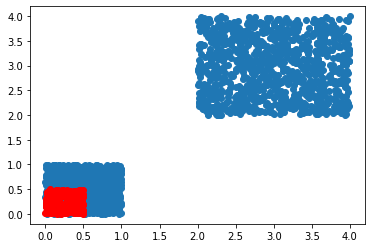

In [34]:
plt.scatter(X[:,0],X[:,1])
plt.scatter(node_vectors_mat[:,0],node_vectors_mat[:,1], color = 'red')

In [35]:
distance_evol = fit(X,
                    node_vectors_mat,
                    n_epochs=100, 
                    n_neighbors=4,
                    n_row=n_row, 
                    n_col=n_col,
                    n_print=1)

epoch=99, distance=480.6737952253339  

We can see in the following plot that as during learning prototypes tend to occupy the upper box of the feature space that was not represented at the start of the learning procedure.

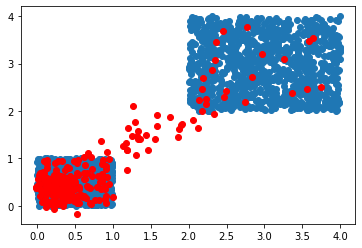

In [36]:
plt.scatter(X[:,0],X[:,1])
plt.scatter(node_vectors_mat[:,0],node_vectors_mat[:,1], color = 'red')

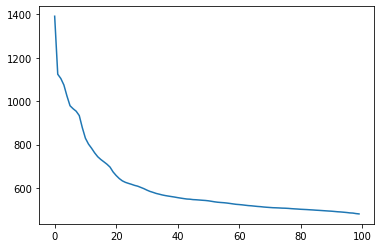

In [37]:
plt.plot(distance_evol)

In [ ]:
distance_evol2 = fit(X,
                    node_vectors_mat,
                    n_epochs=2000, 
                    n_neighbors=2,
                    n_row=n_row, 
                    n_col=n_col,
                    n_print=1)

epoch=1014, distance=378.4009423739838  

In [ ]:
plt.scatter(X[:,0],X[:,1])
plt.scatter(node_vectors_mat[:,0],node_vectors_mat[:,1], color = 'red')

In [ ]:
plt.plot(distance_evol2)